In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
#Model
modelMu = 2
modelSigma = 1.5
def pOf(x):
    return (1.0/(modelSigma*np.sqrt(2.0*np.pi))) * (np.e**(-((x-modelMu)**2)/(2.0*modelSigma**2)))


#MCMC with one parameter
def mcmcOneParam(jump_scale=1,N=10000):
    xChain = [np.random.random()]
    accept = 0
    
    for i in range(0,N):
        y = xChain[i] + np.random.normal(loc=0,scale=jump_scale)
        likelyhood_x = pOf(xChain[i])
        likelyhood_y = pOf(y)
        alpha = np.random.random()
        if (likelyhood_y/likelyhood_x) >= alpha:
            xChain.append(y)
            accept+=1
        else:
            xChain.append(xChain[i])
    
    percent = accept/N
    
    return xChain, percent
    
def showGraphs(jump_scale, chain, acceptance,hist_bins=100):
    print("Percent of jumps accepted: {}%".format(acceptance*100))
    plt.plot(chain)
    plt.title('Chain for Jump Scale={}'.format(jump_scale))
    plt.show()
    plt.hist(chain,bins=hist_bins,density=True)
    plt.title('Histogram for Jump Scale={}'.format(jump_scale))
    plt.show()
    print('-------------------------------------------------')

Percent of jumps accepted: 79.21000000000001%


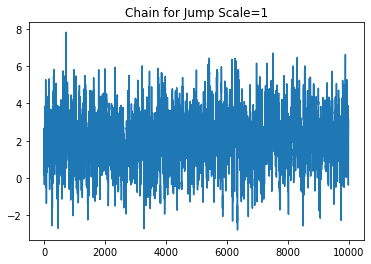

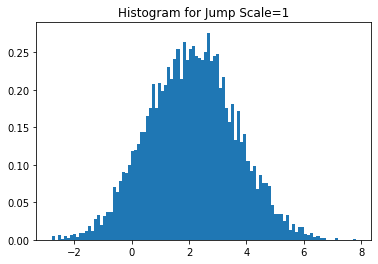

-------------------------------------------------


In [6]:
#Using Previous assignment's mcmc estimate for data
data, dataAcceptance = mcmcOneParam(1)
showGraphs(1,data,dataAcceptance)

In [9]:
#Model to compare guesses with. Greater likelyhood means closer to model
def logLikelyhood(x,mu,sigma):
    retVal = 0
    for i in range(0,len(x)):
        retVal+=-((x[i]-mu)**2)/(2*(sigma**2))
    
    return (len(x)*np.log(1/(sigma*np.sqrt(2*np.pi))))+retVal

In [22]:
def guessGaussian(chain,mu,sigma,N=1000):
    guesses = []
    bestGuess = None
    for i in range(0,N):
        Nmu = np.random.normal(loc=mu, scale=1)
        Nsigma = np.random.normal(loc=sigma, scale=1)
        likelyhood = logLikelyhood(chain,Nmu,Nsigma)
        guesses.append((Nmu,Nsigma,likelyhood))
        if(bestGuess==None or likelyhood > bestGuess[2]):
            bestGuess = (Nmu,Nsigma,likelyhood)
    
    return guesses, bestGuess
    
def guessUniform(chain,mu,sigma,N=1000):
    guesses = []
    best = None
    for i in range(0,N):
        Nmu = (np.random.uniform(mu-1,mu+1))
        Nsigma = (np.random.random()*3)+sigma
        likely = logLikelyhood(chain,Nmu,Nsigma)
        guesses.append([Nmu,Nsigma,likely])
        if(best==None or likely>best[2]):
            best = [Nmu,Nsigma,likely]
        
    return guesses, best

In [23]:
gaussian, bestGaussian = guessGaussian(data, modelMu, modelSigma, N=1000)
uniform, bestUniform = guessUniform(data, modelMu, modelSigma, N=1000)
print("Best guess from gaussian: \nMu={} Sigma={}\nLikelyhood={}".format(bestGaussian[0],bestGaussian[1],bestGaussian[2]))
print("Best guess from uniform: \nMu={} Sigma={}\nLikelyhood={}".format(bestUniform[0],bestUniform[1],bestUniform[2]))

gaussian = np.array(gaussian).swapaxes(0,1)
uniform = np.array(uniform).swapaxes(0,1)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Best guess from gaussian: 
Mu=2.68872578335937 Sigma=-0.9646238621751264
Likelyhood=nan
Best guess from uniform: 
Mu=2.1086675321712223 Sigma=1.516900349056037
Likelyhood=-18395.84660515739


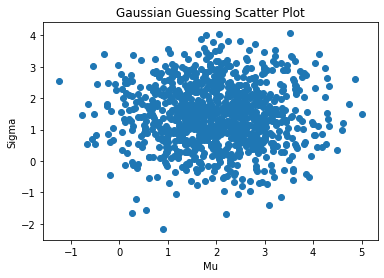

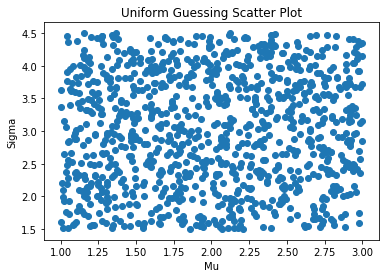

In [27]:
plt.scatter(gaussian[0],gaussian[1])
plt.title("Gaussian Guessing Scatter Plot")
plt.xlabel('Mu')
plt.ylabel('Sigma')
plt.show()

plt.scatter(uniform[0],uniform[1])
plt.title("Uniform Guessing Scatter Plot")
plt.xlabel('Mu')
plt.ylabel('Sigma')
plt.show()

In [29]:
#doing it with an MCMC

def mcmcTwoParams(x,stepSigma=1,N=1000):
    mu = [np.random.random()]
    sigma = [np.random.random()]
    likelyhoods = [logLikelyhood(x,mu[0],sigma[0])]
    accepted = 0
    
    for i in range(0,N):
        newMu = mu[i] + np.random.normal(loc=0,scale=stepSigma)
        newSigma = sigma[i] + np.random.normal(loc=0,scale=stepSigma)
        oldLikely = logLikelyhood(x,mu[i],sigma[i])
        newLikely = logLikelyhood(x,newMu,newSigma)
        logH=newLikely-oldLikely
        if logH>0:
            mu.append(newMu)
            sigma.append(newSigma)
            accepted+=1
        else:
            logAlpha = np.log(np.random.random())
            if logH >= logAlpha:
                mu.append(newMu)
                sigma.append(newSigma)
                likelyhoods.append(newLikely)
                accepted+=1
            else:
                mu.append(mu[i])
                sigma.append(sigma[i])
                likelyhoods.append(oldLikely)
    
    acceptedPercent = accepted/N
    
    return mu, sigma, likelyhoods, acceptedPercent


In [37]:
step_sigma = .003
N = 30000
burn = int(.25 *N)
hist_bins = 100

temp = estimateMuSigma(data,step_sigma,N)
muChain, sigmaChain, likelyhoods, acceptance = temp

Accepted: 86.14%


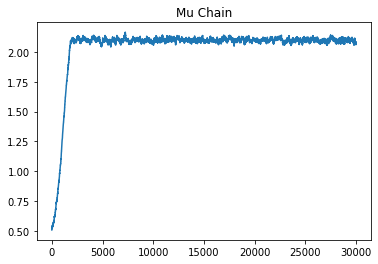

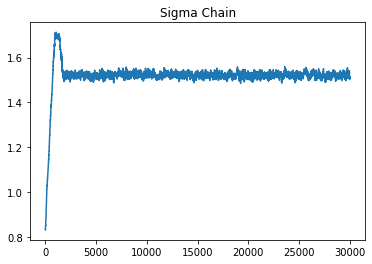

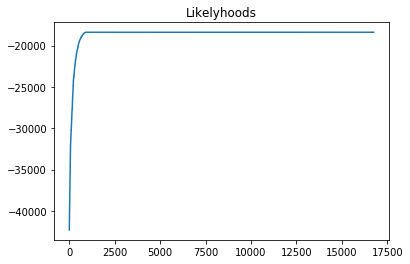

Histograms:


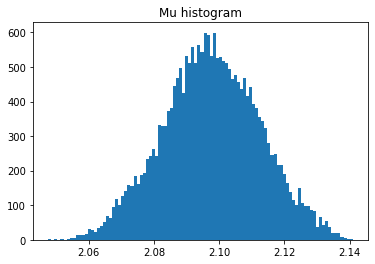

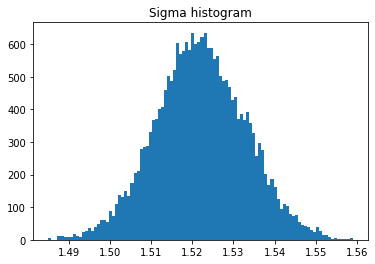

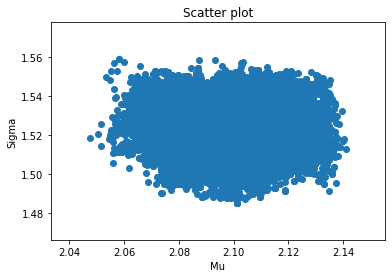

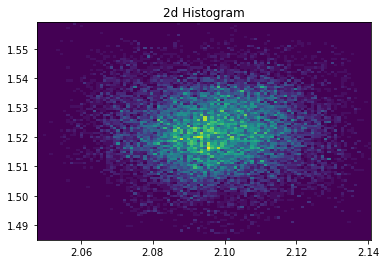

In [41]:
print("Accepted: "+ str(acceptance*100)+"%")
plt.plot(muChain)
plt.title("Mu Chain")
plt.show()
plt.plot(sigmaChain)
plt.title('Sigma Chain')
plt.show()
plt.plot(likelyhoods)
plt.title("Likelyhoods")
plt.show()
print("Histograms:")
plt.hist(muChain[burn:],bins=hist_bins)
plt.title('Mu histogram')
plt.show()
plt.hist(sigmaChain[burn:],bins=hist_bins)
plt.title('Sigma histogram')
plt.show()
plt.scatter(muChain[burn:],sigmaChain[burn:])
plt.title('Scatter plot')
plt.xlabel('Mu')
plt.ylabel('Sigma')
plt.show()
plt.hist2d(muChain[burn:],sigmaChain[burn:],density=True,bins=100)
plt.title('2d Histogram')
plt.show()